In [2]:
from pathlib import Path
from pprint import pprint
from typing import List, Tuple
import pickle

import matplotlib.pyplot as plt

from pos import evaluate
from pos import data

EXPERIMENT_DIR=Path(".")/"out"

## Read the experiment files
Here are some useful functions for gathering experimental data and doing averages across folds.

In [21]:
def gather_experiments(experiment_paths):
    return [
        evaluate.Experiment(experiment_path) for experiment_path in experiment_paths
    ]

def print_errors(experiments):
    for experiment_name in experiments:
        print(experiment_name)
        errors = evaluate.all_errors(experiments[experiment_name]["examples"])
        pprint(errors.most_common(20))

def pretty_print_average_experiments(name: str, results: List[Tuple[float, int]]) -> str:
    """Return a nicely formatted aggregate of a collection of experiments."""
    names = ["tot", "unk", "kno", "mor", "wmb", "pre", "chr"]
    print(f"{name:<15}: ", end="")
    for result, name in zip(results, names):
        print(f"{format_acc_total(name, *result)}", end="")
    print()

def format_acc_total(name: str, acc: float, total: int) -> str:
    """Format accuracy and total incorrect."""
    return f"{name:<5}={acc*100:>02.2f}% / {total:>4d} "


def create_pie_chart(name: str, results: List[Tuple[float, int]]):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    total, unknown, known, rest = results[0], results[1], results[2], results[3:]
    labels = ["k-wemb", "k-wemb+m", "k-m", "seen", "u-wemb", "u-wemb+m", "u-m", "unseen"]
    labels = [f"{name}={acc*100:>02.2f}% / {total}" for name, (acc, total) in zip(labels, rest) if total > 0]
    sizes = [total for _, total in rest if total > 0]

    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(111)
    patches, _ = ax.pie(sizes, labels=labels, startangle=90)
    ax.axis('equal')
    ax.set_title(label=f"""{name}
Total={total[0]*100:>02.2f}% / {total[1]}
Unknown={unknown[0]*100:>02.2f}% / {unknown[1]}
Known={known[0]*100:>02.2f}% / {known[1]}""", loc='left')
    ax.legend(patches, labels, loc='upper right', bbox_to_anchor=(1.1, 1.05))
    return fig

### Folds

In [44]:
fold_experiments = {
    "pre": gather_experiments(EXPERIMENT_DIR / "gold-pretrained-only" / f"{i:02}" for i in range(1, 10)),
    "pre-slow": gather_experiments(EXPERIMENT_DIR / "gold-pretrained-0.002" / f"{i:02}" for i in range(1, 10)),
}

In [45]:
averages = [(name, evaluate.all_accuracy_average(experiments)) for name, experiments in fold_experiments.items()]
    

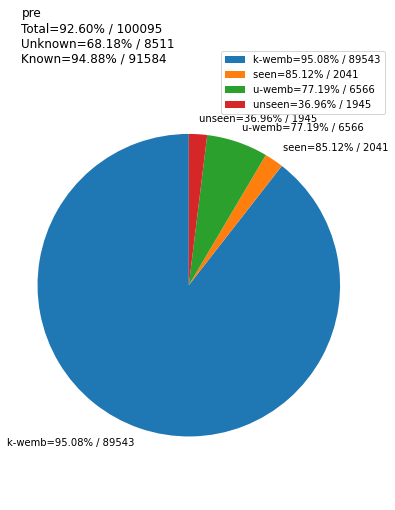

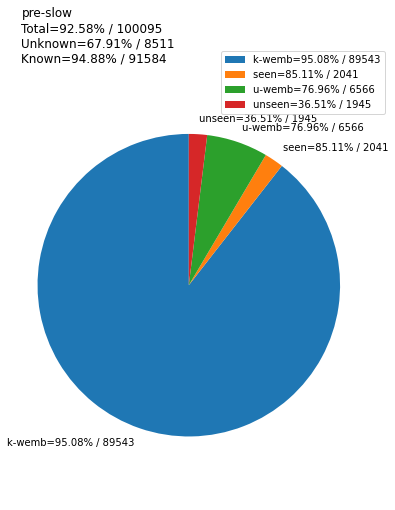

In [46]:
for name, average in averages:
    create_pie_chart(name, average).show()

In [6]:
for name, average in averages:
    pretty_print_average_experiments(name, average)

base           : tot  =94.54% / 100095 unk  =80.29% / 8511 kno  =95.87% / 91584 mor  =97.66% / 18399 wmb  =95.42% / 73185 pre  =0.00% /    0 chr  =0.00% /    0 
char+wemb      : tot  =93.43% / 100095 unk  =71.36% / 8511 kno  =95.48% / 91584 mor  =95.48% / 91584 wmb  =0.00% /    0 pre  =0.00% /    0 chr  =0.00% /    0 
char           : tot  =91.16% / 100095 unk  =71.39% / 8511 kno  =93.00% / 91584 mor  =0.00% /    0 wmb  =0.00% /    0 pre  =0.00% /    0 chr  =93.00% / 91584 
wemb           : tot  =88.51% / 100095 unk  =20.27% / 8511 kno  =94.85% / 91584 mor  =94.85% / 91584 wmb  =0.00% /    0 pre  =0.00% /    0 chr  =0.00% /    0 
pretrained     : tot  =92.60% / 100095 unk  =68.18% / 8511 kno  =94.88% / 91584 mor  =95.08% / 89543 wmb  =0.00% /    0 pre  =0.00% /    0 chr  =85.12% / 2041 
morph          : tot  =85.42% / 100095 unk  =58.68% / 8511 kno  =87.90% / 91584 mor  =0.00% /    0 wmb  =0.00% /    0 pre  =94.19% / 73185 chr  =62.93% / 18399 
morph+char     : tot  =94.12% / 100095 un

## Individual experiments
Define individual experiments and do analysis.


In [3]:
#baseline = "abl-tagger-baseline"
experiment_names = [
    #baseline,
    EXPERIMENT_DIR / "test",
]
experiments = gather_experiments(experiment_names)

In [4]:
for experiment in experiments:
    print(experiment)


|t-V|=20766, |k-V|=13560, |u-V|=7206, |m-only-V|=3983, |w-only-V|=2594, |p-only-V|=0, t-acc=86.645% / 99366, u-acc=56.961% / 8720, k-acc=89.501% / 90646, m-only-acc=83.872% / 4830, w-only-acc=85.254% / 21030, p-only-acc=0.000% / 0, 


In [9]:
print(len(experiments[0].wemb_vocab()))
print(len(experiments[0].morphlex_vocab()))
print(len(experiments[0].morphlex_vocab().difference(experiments[0].wemb_vocab())))
print(len(experiments[0].wemb_vocab().difference(experiments[0].morphlex_vocab())))

13560
14949
3983
2594


### Errors
Proposed tag -> gold tag

In [ ]:
print_errors(experiments)


In [ ]:
def get_error_diff(baseline, compare_to):
    result = {}
    for key, value in baseline.items():
        if key not in compare_to:
            result[key] = basline[key]
            continue
        diff = baseline[key] - compare_to[key]
        if diff != 0:
            result[key] = diff
    return result

            

In [ ]:
from collections import Counter
c_1 = Counter((1, 1, 2))
c_2 = Counter((1, 1, 3))
print(c_1 - c_2)

In [ ]:
baseline = "sgd+morph_lex-freeze+wemb-pretrained-300-reduced-lr"
baseline_errors = evaluate.all_errors(experiments[baseline]["examples"])
for experiment_name in experiments:
    if experiment_name == baseline:
        continue
    print(f"{experiment_name}: First, in basline not in {experiment_name}, then in {experiment_name} not in basline.")
    pprint((evaluate.all_errors(experiments[baseline]["examples"]) - evaluate.all_errors(experiments[experiment_name]["examples"])).most_common(20))
    pprint((evaluate.all_errors(experiments[experiment_name]["examples"]) - evaluate.all_errors(experiments[baseline]["examples"])).most_common(20))